Same as mantid_waterIN5_fit3 using improved Python notation for definining fit models, which has been available since Mantid release 3.12 (should check). 

Also since 31st May 2018 it is possible within a Python session to define/import new fit function and use them. Previously such would only be available within the Mantid C++ framework but not exposed to out to Python.

For this notebook to work do:

* (not required in version below yet: Install a night build of Mantid dating from 31st May 2018 onwards or a Mantid release released after this date)
* On Windows from a command prompt type: c:/MantidInstall/bin/mantidpython.bat notebook

For more info on working with IPython/Jupyter and Mantid see also: http://www.mantidproject.org/Using_IPython_Notebook

**Setup Mantid**

In [1]:
import sys
import os

#Tell python where Mantid is installed.
#The official packages put this information in an environment variable called "MANTIDPATH"
sys.path.append(os.environ['MANTIDPATH'])

#We can now import Mantid's Python API
from mantid.simpleapi import *

**Setup matplotlib, numpy etc**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import pi

#Some magic to tell matplotlib how to behave in IPython Notebook
%matplotlib inline

In [3]:
# Path to where the data for the examples are (/QENSmodels/examples/data)
path_to_data = os.path.join(os.getcwd(), 'data/')

# experimental data
ws_5Aini = LoadLamp(path_to_data+'H2O_293K_5A.hdf')

# vanadium
res_5Aini = LoadLamp(path_to_data+'V_273K_5A.hdf')

hw_5A = ws_5Aini.readX(0)

idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
index_4_trunc_5A = idx_5A[0].tolist()

print(ws_5Aini.getNumberHistograms(), ws_5Aini.blocksize())
print(res_5Aini.getNumberHistograms(), res_5Aini.blocksize())

(17, 160)
(17, 160)


In [4]:
# Force resolution function to have unit area
norm_res_5A = CloneWorkspace(res_5Aini)

for i in range(res_5Aini.getNumberHistograms()):
    area = Integration(res_5Aini, StartWorkspaceIndex=i, EndWorkspaceIndex=i)
    y_norm = norm_res_5A.dataY(i)
    y_norm /= area.readY(0)[0]

# Fit range -1meV < energy < 1 meV
x = hw_5A[index_4_trunc_5A]

# Apply truncation to data
ws_5A = CropWorkspace(ws_5Aini, XMin=-1, Xmax=1)

# Same procedure for normalised resolution
res_5A = CropWorkspace(norm_res_5A,  XMin=-1, XMax=1)

# Extract values of q to be used in parameters of fitting models
q_5A = ws_5A.getAxis(1).extractValues()

# Remove invalid data (negative errors)
for ii in range(len(q_5A)):
    yy = ws_5A.dataY(ii)
    err = ws_5A.dataE(ii)
    for jj in range(ws_5A.blocksize()):
        if err[jj] <= 0:
            yy[jj] = 0
            err[jj] = 0

In [5]:
""" Fitting Model:
 S(Q,E) = Convolution(Resolution, IsoRotDiff + Lorentzian with fwhm proportional to Q**2)
 We do a global fit (all spectra)
"""

N = 6  # maximum number of components for IsoRotDiff
single_model_template="""(composite=Convolution,FixResolution=true,NumDeriv=true;\
name=Resolution,Workspace=res_5A,WorkspaceIndex=_WI_;\
(name=IsoRotDiff,Q=_Q_,f0.Height=20,f0.Centre=0,f0.Radius=0.98,Tau=2.;\
name=UserFunction, Formula=scale_factor*D*Q*Q/{pi}/( (x-Centre)*(x-Centre) + D*D*Q*Q*Q*Q ), scale_factor=20, Centre=0., D=0.1, Q=_Q_);\
ties=(f1.f0.f0.Height=f1.f1.scale_factor))""".format(pi=pi)

In [6]:
boevs_template = single_model_template.replace("_Q_", str(0.1))
boevs = boevs_template.replace("_WI_", str(0))
boevs

'(composite=Convolution,FixResolution=true,NumDeriv=true;name=Resolution,Workspace=res_5A,WorkspaceIndex=0;(name=IsoRotDiff,Q=0.1,f0.Height=20,f0.Centre=0,f0.Radius=0.98,Tau=2.;name=UserFunction, Formula=scale_factor*D*Q*Q/3.14159265359/( (x-Centre)*(x-Centre) + D*D*Q*Q*Q*Q ), scale_factor=20, Centre=0., D=0.1, Q=0.1);ties=(f1.f0.f0.Height=f1.f1.scale_factor))'

**Here a start at using improved format for setting up a model**

In [7]:
res_func = Resolution(Workspace='res_5A',WorkspaceIndex=0)
user_func = UserFunction(Formula = 'scale_factor*D*Q*Q/3.61/( (x-Centre)*(x-Centre) + D*D*Q*Q*Q*Q )', scale_factor=20, Centre=0., D=0.1, Q=0.1)
iso_rot_diff_func = IsoRotDiff(Q=0.1, Height=20, Centre=0, Radius=0.98, Tau=2.)
my_model =  iso_rot_diff_func + user_func
#my_model.tie({'f0.Height': 'f1.scale_factor'})

my_func = Convolution(res_func, my_model)
print(my_func)


#md_fun = MultiDomainFunction(Gaussian(PeakCentre=1, Sigma=0.1), Gaussian(PeakCentre=1, Sigma=0.2), ..., Global=['Height'])

composite=Convolution,FixResolution=true,NumDeriv=true;name=Resolution,Workspace=res_5A,WorkspaceIndex=0,X=(),Y=();((name=IsoRotDiff,N=25,NumDeriv=false,Q=0.10000000000000001,f0.Height=1,f0.Centre=0,f0.Radius=0.98,Height=1,Radius=0.98,Tau=2,Centre=0);name=UserFunction,Formula=scale_factor*D*Q*Q/3.61/((x-Centre)*(x-Centre)+D*D*Q*Q*Q*Q),scale_factor=20,D=0.1,Q=0.1,Centre=0)


In [8]:
# Now create the string representation of the global model (all spectra, all Q-values):
global_model="composite=MultiDomainFunction,NumDeriv=true;"
wi = 0
for Q in q_5A:
    single_model = single_model_template.replace("_Q_", str(Q))  # insert Q-value
    single_model = single_model.replace("_WI_", str(wi))  # workspace index
    global_model += "(composite=CompositeFunction,NumDeriv=true,$domains=i;{0});\n".format(single_model)
    wi+=1
# The Radius, Tau, and D are the same for all spectra, thus tie them:
ties = ['='.join(["f{0}.f0.f1.f0.f0.Radius".format(wi) for wi in reversed(range(len(q_5A)))]),
   '='.join(["f{0}.f0.f1.f0.f1.Tau".format(wi) for wi in reversed(range(len(q_5A)))]),
   '='.join(["f{0}.f0.f1.f1.D".format(wi) for wi in reversed(range(len(q_5A)))])]
global_model += "ties=("+','.join(ties)+')'  # tie Radius, Tau and D

In [9]:
# Now relate each domain(i.e. spectrum) to each single model
domain_model = dict()
for wi in range(len(q_5A)):
    if wi == 0:
        domain_model.update({"InputWorkspace": ws_5A.name(), "WorkspaceIndex": str(wi),
            "StartX": "-1", "EndX": "1"})
    else:
        domain_model.update({"InputWorkspace_"+str(wi): ws_5A.name(), "WorkspaceIndex_"+str(wi): str(wi),
            "StartX_"+str(wi): "-1", "EndX_"+str(wi): "1"})

In [10]:
# Invoke the Fit algorithm using global_model and domain_model:
output_workspace = "glofit_"+ws_5A.name()
fit_output = Fit(Function=global_model, Output=output_workspace, CreateOutput=True, MaxIterations=500, **domain_model)

# Print some results
fitWorkspace = fit_output.OutputWorkspace
paramTable = fit_output.OutputParameters

# print results for refined parameters
print('Table of refined parameters: Name Value Error')

for i in range(paramTable.rowCount()):
    print(paramTable.column(0)[i],
          paramTable.column(1)[i],
          paramTable.column(2)[i])

Table of refined parameters: Name Value Error
('f0.f0.f1.f0.f0.Height', 19.636160532561593, 0.0)
('f0.f0.f1.f0.f0.Centre', -0.0023145306996683822, 0.4121758885950229)
('f0.f0.f1.f0.f0.Radius', 7.6408928761693495, 0.028533426444864424)
('f0.f0.f1.f0.Height', 19.636160532561593, 0.0)
('f0.f0.f1.f0.Radius', 7.6408928761693495, 0.0)
('f0.f0.f1.f0.Tau', 0.2828590482345675, 0.0024975521823571364)
('f0.f0.f1.f0.Centre', -0.0023145306996683822, 0.0)
('f0.f0.f1.f1.scale_factor', 19.636160532561593, 0.01439328539294581)
('f0.f0.f1.f1.D', 0.1073532458818878, 0.08794202854551367)
('f0.f0.f1.f1.Q', 0.5870943936527047, 0.24043659778262094)
('f0.f0.f1.f1.Centre', 0.0005869305372810858, 5.003571712721771e-05)
('f1.f0.f1.f0.f0.Height', 19.601216408663166, 0.0)
('f1.f0.f1.f0.f0.Centre', -0.013035208471818167, 2.5995856702882794)
('f1.f0.f1.f0.f0.Radius', 7.6408928761693495, 0.0)
('f1.f0.f1.f0.Height', 19.601216408663166, 0.0)
('f1.f0.f1.f0.Radius', 7.6408928761693495, 0.0)
('f1.f0.f1.f0.Tau', 0.28285904

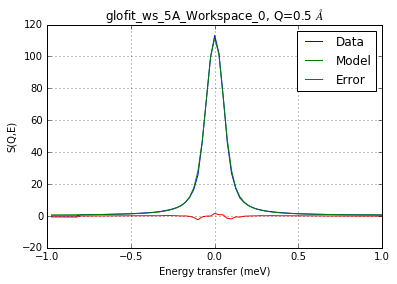

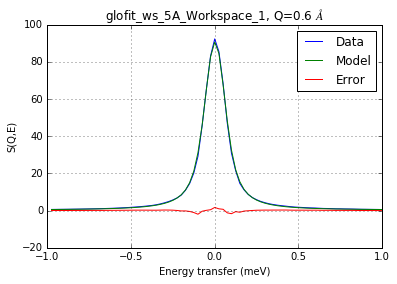

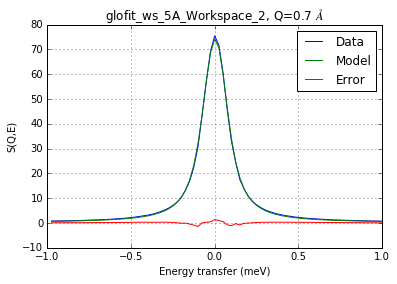

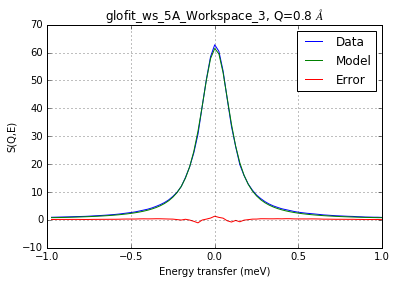

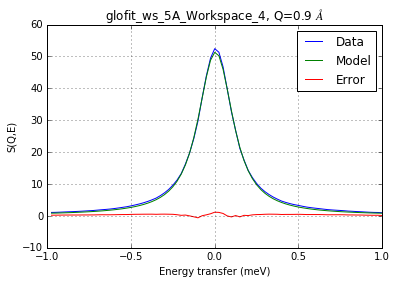

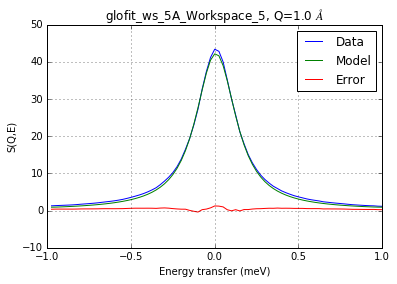

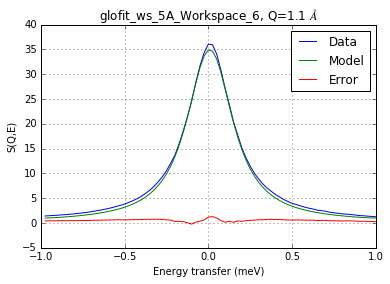

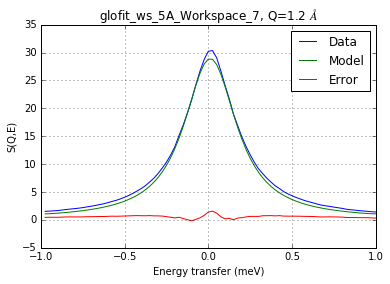

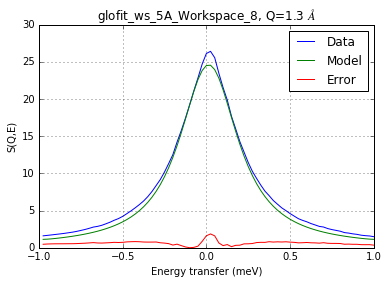

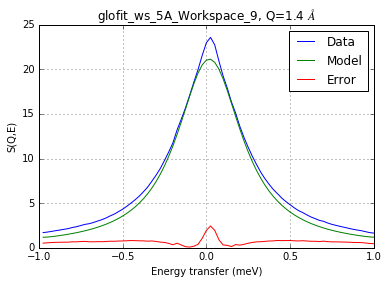

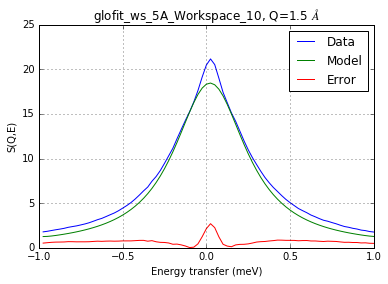

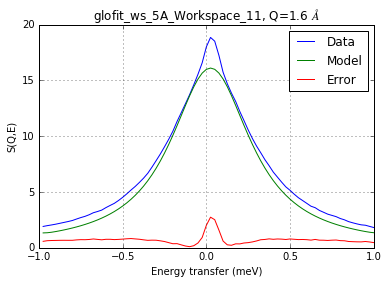

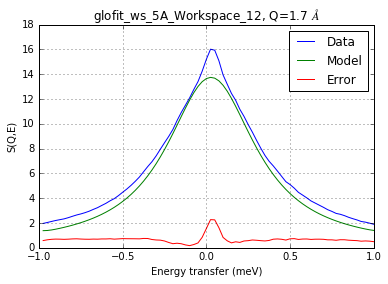

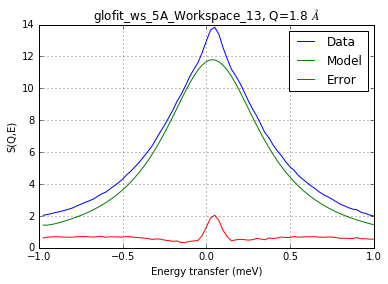

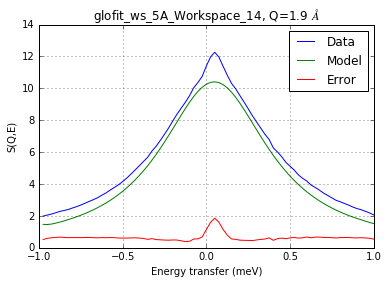

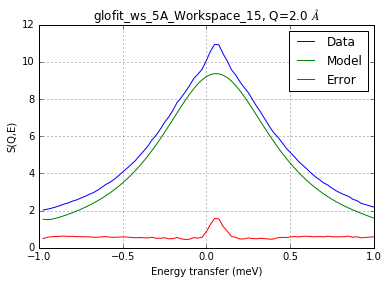

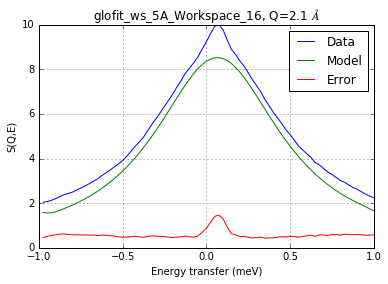

In [11]:
# Plot results: one plot / spectrum showing experimental, fitted data
# and difference

for indx, item in enumerate(fitWorkspace.getNames()):
    x = mtd[item].readX(0)
    plt.plot(x, mtd[item].readY(0), label="Data")
    plt.plot(x, mtd[item].readY(1), label="Model")
    plt.plot(x, mtd[item].readY(2), label="Error")
    plt.xlabel('Energy transfer (meV)')
    plt.ylabel('S(Q,E)')
    plt.legend()
    plt.grid()
    plt.title(item + r", Q={:.1f} $\AA$".format(q_5A[indx]))
    plt.show()
